### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
import os
start_token = " "

with open("names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + line for line in lines]

In [3]:
print ('n samples = ',len(lines))
for x in lines[::1000]:
    print (x)
    


n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


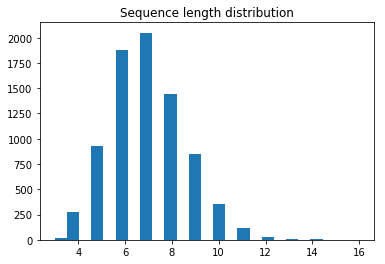

In [4]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [5]:
#all unique characters go here
tokens = set([x for y in lines for x in y])

tokens = list(tokens)

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [6]:
token_to_id = dict(zip(tokens, np.arange(len(tokens))))

In [7]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [130]:
def to_matrix(lines, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = False):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_id[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        lines_ix = np.transpose(lines_ix)

    return lines_ix

In [9]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[39 30 18 47  1 47 16 53 39]
 [39  2 53 54 10 22 39 39 39]
 [39 34 10 38 40 40 38 16 39]
 [39  2 38 54  8 47  0  0 16]]


# Recurrent neural network


In [10]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [511]:
import torch, torch.nn as nn
import torch.nn.functional as F

class CharLSTM(nn.Module):
    """
    Implements something like CharRNNCell, but with LSTM
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.emb_layer = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(embedding_size, rnn_num_units, 3)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def step(self, x, prev_state):
        (prev_h, prev_c) = prev_state
        (next_h, next_c) = self.lstm(self.emb(x), (prev_h, prev_c))
        logits = self.rnn_to_logits(next_h)
        
        return (next_h, next_c), F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ LSTM has two state variables, cell and hid """
        return torch.zeros(3, batch_size, self.num_units), torch.zeros(3, batch_size, self.num_units)
    
    def forward(self, sentence):
        embs = self.emb_layer(sentence)
       
        
        self.hidden = self.initial_state(embs.shape[1])

        out, hidden = self.lstm(embs, self.hidden)
        
        logits = self.rnn_to_logits(out)
        
        return F.log_softmax(logits, -1)
    
char_lstm = CharLSTM()

## Train

In [512]:
from IPython.display import clear_output
from random import sample

opt = torch.optim.Adam(char_lstm.parameters())
history = []

In [513]:
loss_func = nn.NLLLoss()

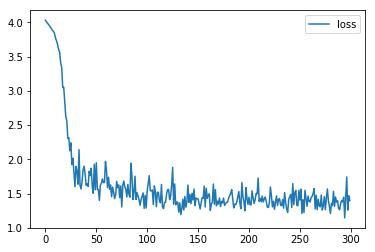

In [514]:

for i in range(300):
    batch_ix = to_matrix(sample(lines, 10), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    
    out = char_lstm(batch_ix)

    loss = loss_func(torch.flatten(out[:-1], 0, 1), batch_ix[1:].flatten())
    
    loss.backward()
    
    opt.step()
    opt.zero_grad()
    
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 


In [506]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #print("seq", x_sequence)

    for _ in range(max_length - len(seed_phrase)):
        logp_next = char_rnn(torch.transpose(x_sequence, 1, 0))[-1,0]
        p_next = torch.exp(logp_next).data.numpy()
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [515]:
for _ in range(10):
    print(generate_sample(char_lstm, seed_phrase=" "))

 yuirnf         
 eelilil        
 lBelyy         
 tyary          
 Davey          
 rbirii         
 oeumlu         
 ePr n          
 JdVeoan        
 mrL            


In [516]:
for _ in range(50):
    print(generate_sample(char_lstm, seed_phrase=' Trump'))

 Trumpse        
 Trumped        
 Trump          
 Trumpeh        
 Trumpa         
 Trumpey        
 Trumpll        
 Trumpad        
 Trumpaei       
 Trumpo         
 Trumpc         
 Trump          
 Trump          
 Trump          
 Trump a l      
 Trumps         
 Trumpa         
 Trump          
 Trumphe        
 Trumpei        
 Trump a        
 Trumplca       
 Trumpo   t     
 Trumpi         
 Trumpnat       
 Trumpr    r    
 Trumpniae      
 Trumpo         
 Trumpci        
 Trump          
 Trump          
 Trumpt         
 Trumpi         
 Trumpi         
 Trumpwhi       
 Trumps         
 Trumpaen       
 Trumphe        
 Trumpn         
 Trumpa u       
 Trumpn         
 Trumpdd        
 Trumprle       
 Trump          
 Trump          
 Trumpt         
 Trump          
 Trumplk        
 Trump          
 Trump          
